## Individual Analysis

In [78]:
# Folder to be analyzed
path = "../experiment_output/Experiment4/exp4_l2_init0.2/experiments_exp4_l2_init0.2_5"

### Analyze Sparsity

In [79]:
import torch
import os

def load_model_weights(model_path):
    """Load model weights from a .pth file."""
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model_state = checkpoint["student_model_state_dict"]
    return {k: v.cpu().numpy() for k, v in model_state.items() if "weight" in k}

def compute_sparsity(weights_dict):
    """Compute the sparsity of model weights (per layer)."""
    sparsity = {}
    for layer_name, weights in weights_dict.items():
        num_elements = weights.size
        num_zeros = (abs(weights) < 1e-4).sum()
        sparsity[layer_name] = num_zeros / num_elements    
    return sparsity

def compute_layerwise_sparsity(directory):
    """Compute and print layer-wise sparsity for each model in a folder."""
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.endswith(".pth"):
                continue

            model_path = os.path.join(root, file)
            weights_dict = load_model_weights(model_path)
            sparsity = compute_sparsity(weights_dict)

            print(f"\nModel: {file}")
            for layer_name, sparsity_value in sparsity.items():
                print(f"  {layer_name}: {sparsity_value * 100:.2f}% sparsity")

In [80]:
compute_layerwise_sparsity(path)


Model: nonoverlappingCNN_sigmoid__fcnn_sigmoid.pth
  layers.0.weight: 0.59% sparsity
  layers.1.weight: 6.65% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_sigmoid__fcnn_relu.pth
  layers.0.weight: 0.07% sparsity
  layers.1.weight: 0.45% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_relu__fcnn_tanh.pth
  layers.0.weight: 0.00% sparsity
  layers.1.weight: 0.02% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_tanh__fcnn_sigmoid.pth
  layers.0.weight: 1.37% sparsity
  layers.1.weight: 34.69% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_tanh__fcnn_relu.pth
  layers.0.weight: 0.26% sparsity
  layers.1.weight: 0.32% sparsity
  layers.2.weight: 0.00% sparsity

Model: nonoverlappingCNN_tanh__fcnn_tanh.pth
  layers.0.weight: 1.43% sparsity
  layers.1.weight: 15.97% sparsity
  layers.2.weight: 0.78% sparsity

Model: nonoverlappingCNN_relu__fcnn_relu.pth
  layers.0.weight: 15.10% sparsity
  layers.1.weight

### Look at heatmaps

In [81]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec

def load_model_weights(model_path):
    """Load model weights from a .pth file."""
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model_state = checkpoint["student_model_state_dict"]
    return {k: v.cpu().numpy() for k, v in model_state.items() if "weight" in k}

def create_heatmaps(weights_dict):
    num_layers = len(weights_dict)

    height_ratios = []
    for i in range(num_layers):
        if i == 1:
            height_ratios.append(2.0)  # Layer 2
        elif i == 2:
            height_ratios.append(1.5)  # Layer 3
        else:
            height_ratios.append(1.0)  # Others

    total_height = sum(height_ratios)
    fig = plt.figure(figsize=(10, 1.5 * total_height))
    gs = gridspec.GridSpec(num_layers, 1, height_ratios=height_ratios, hspace=0.25)
    axes = [fig.add_subplot(gs[i]) for i in range(num_layers)]
    
    im = None

    for i, (layer_name, weights) in enumerate(weights_dict.items()):
        ax = axes[i]
        rows, cols = weights.shape

        # Rotate if vertical
        if rows > cols:
            weights = weights.T
            rows, cols = weights.shape

        # Heatmap
        im = ax.imshow(weights, cmap="RdBu", aspect="equal", vmin=-2, vmax=2)

        clean_name = f"Layer {int(layer_name.split('.')[1]) + 1}"
        ax.set_title(f"{clean_name} (dimension {rows}×{cols})", fontsize=11, pad=4)
        ax.invert_yaxis()
        if rows == 1:
            ax.set_yticks([])

    # Add slim colorbar well outside the plots
    cbar_ax = fig.add_axes([0.91, 0.27, 0.015, 0.64])  # Shifted right to avoid overlap
    fig.colorbar(im, cax=cbar_ax)

    plt.subplots_adjust(left=0.06, right=0.88, top=0.94, bottom=0.06)

    # Slightly shift Layer 3 down
    for i, ax in enumerate(axes):
        if i == 2:
            pos = ax.get_position()
            ax.set_position([pos.x0, pos.y0 + 0.09, pos.width, pos.height])

    plt.show()


In [82]:
def create_all_heatmaps(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith(".pth")]
    for model_file in model_files:
        model_path = os.path.join(directory, model_file)
        print(f"\nLoading weights from {model_file}...")
        
        weights_dict = load_model_weights(model_path)
        create_heatmaps(weights_dict)
        sparsity = compute_sparsity(weights_dict)
        for layer_name, sparsity_value in sparsity.items():
            print(f"Sparsity of {layer_name}: {sparsity_value * 100:.2f}%")


Loading weights from nonoverlappingCNN_sigmoid__fcnn_sigmoid.pth...


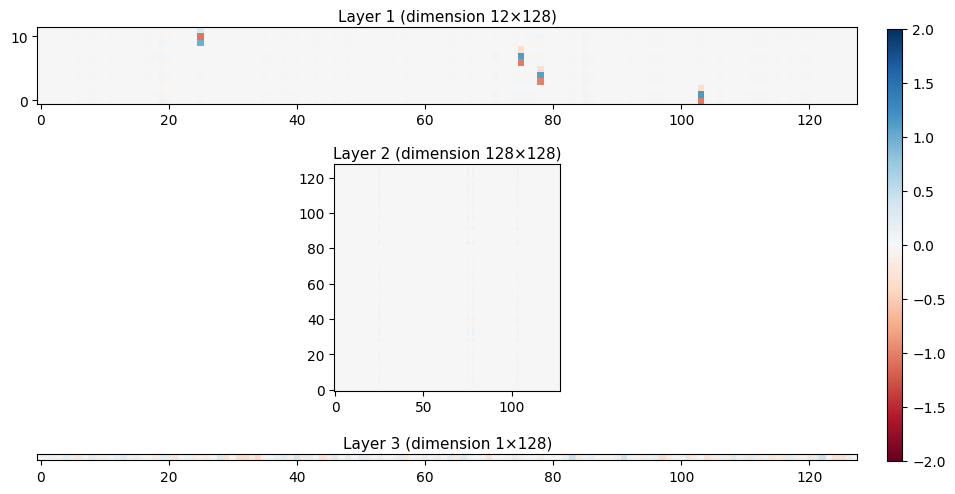

Sparsity of layers.0.weight: 0.59%
Sparsity of layers.1.weight: 6.65%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_sigmoid__fcnn_relu.pth...


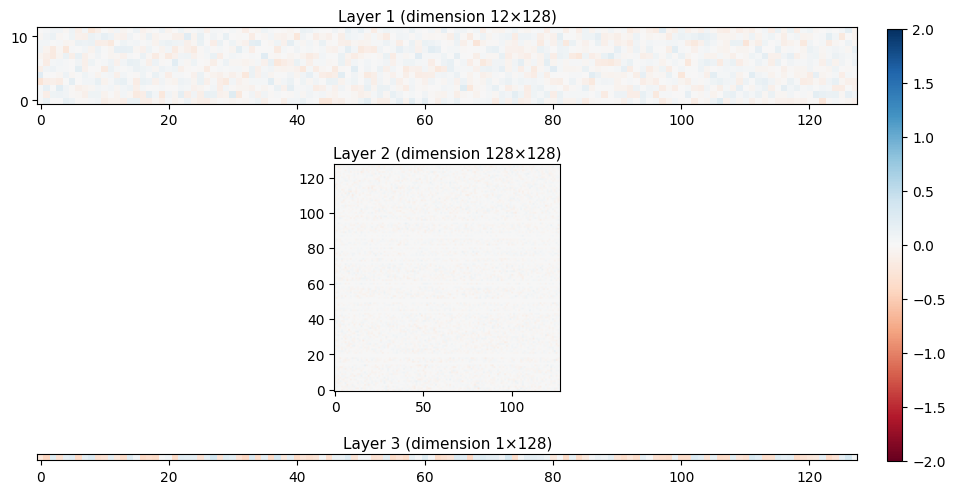

Sparsity of layers.0.weight: 0.07%
Sparsity of layers.1.weight: 0.45%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_relu__fcnn_tanh.pth...


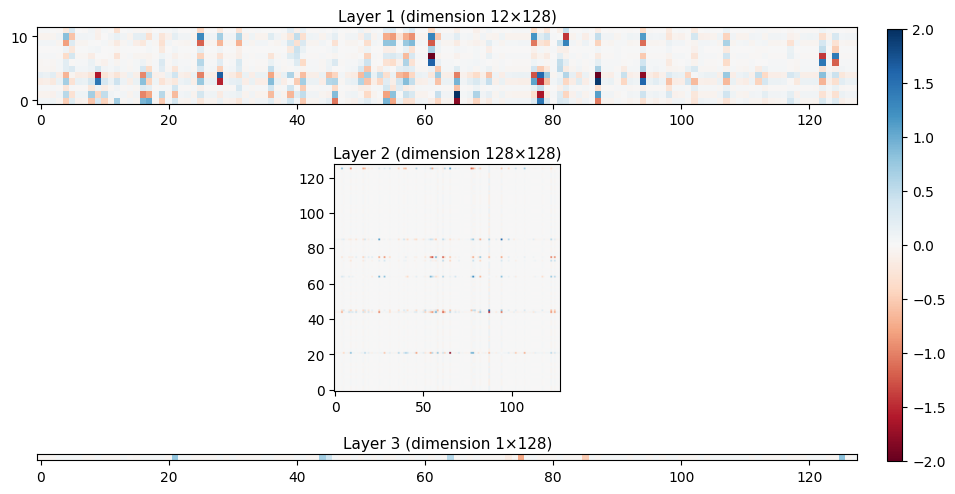

Sparsity of layers.0.weight: 0.00%
Sparsity of layers.1.weight: 0.02%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_tanh__fcnn_sigmoid.pth...


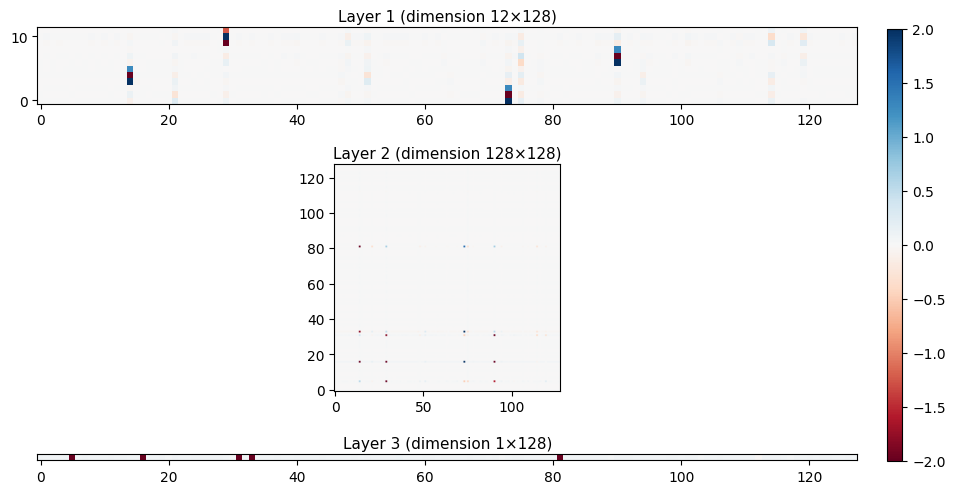

Sparsity of layers.0.weight: 1.37%
Sparsity of layers.1.weight: 34.69%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_tanh__fcnn_relu.pth...


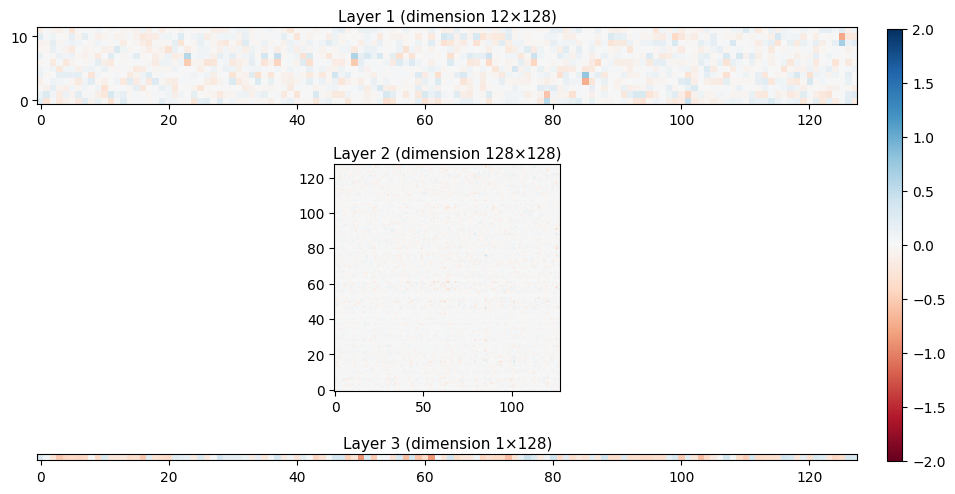

Sparsity of layers.0.weight: 0.26%
Sparsity of layers.1.weight: 0.32%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_tanh__fcnn_tanh.pth...


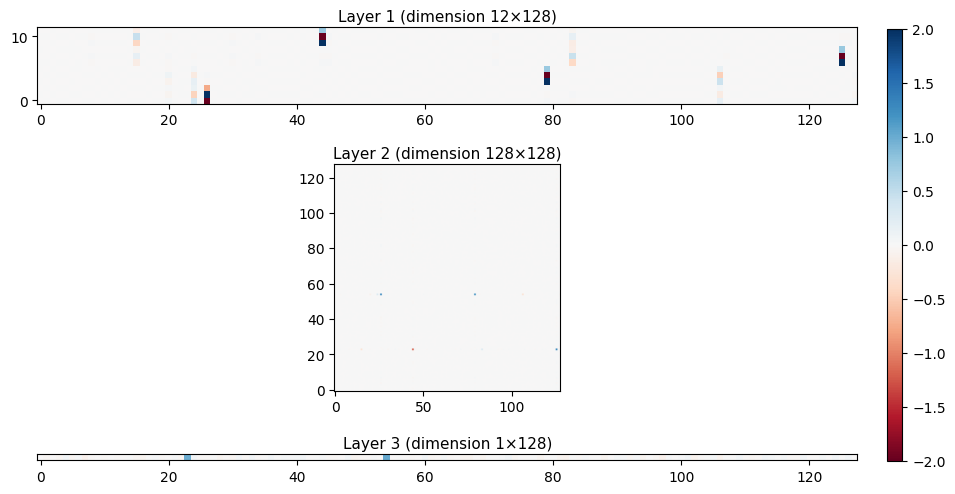

Sparsity of layers.0.weight: 1.43%
Sparsity of layers.1.weight: 15.97%
Sparsity of layers.2.weight: 0.78%

Loading weights from nonoverlappingCNN_relu__fcnn_relu.pth...


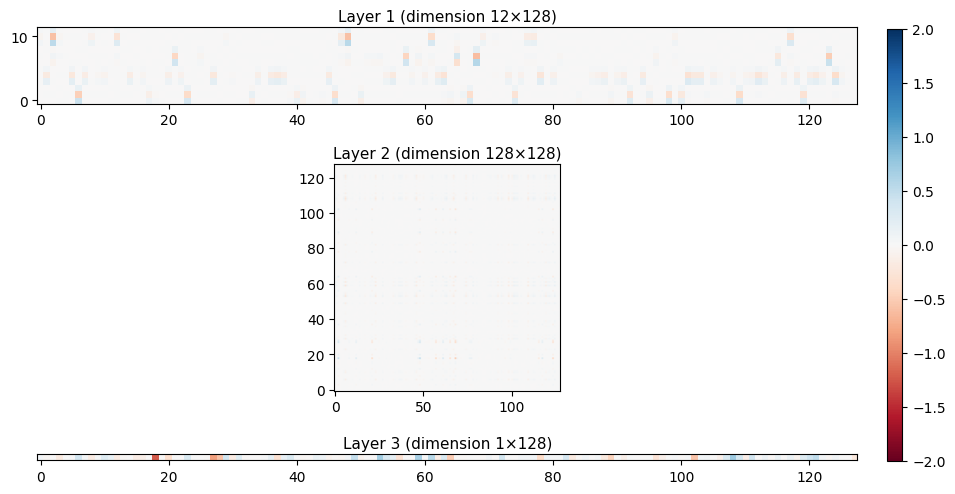

Sparsity of layers.0.weight: 15.10%
Sparsity of layers.1.weight: 28.00%
Sparsity of layers.2.weight: 1.56%

Loading weights from nonoverlappingCNN_relu__fcnn_sigmoid.pth...


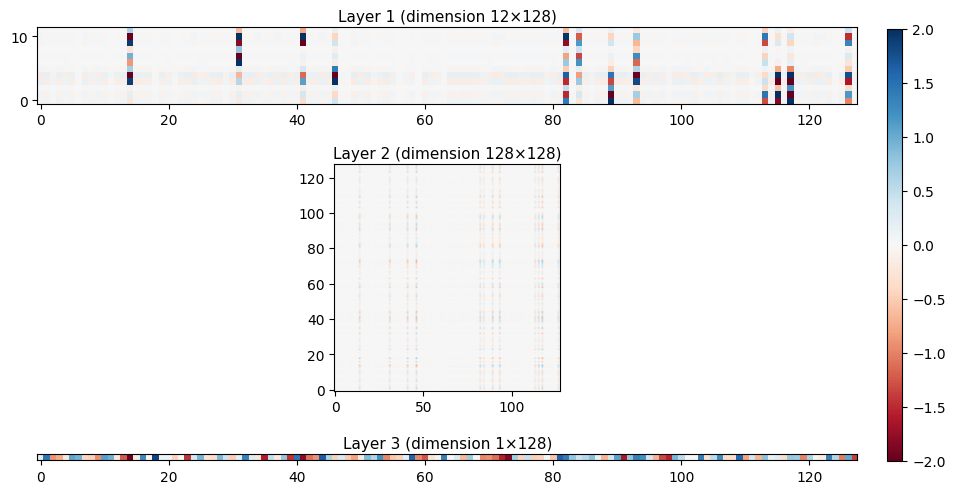

Sparsity of layers.0.weight: 0.20%
Sparsity of layers.1.weight: 0.21%
Sparsity of layers.2.weight: 0.00%

Loading weights from nonoverlappingCNN_sigmoid__fcnn_tanh.pth...


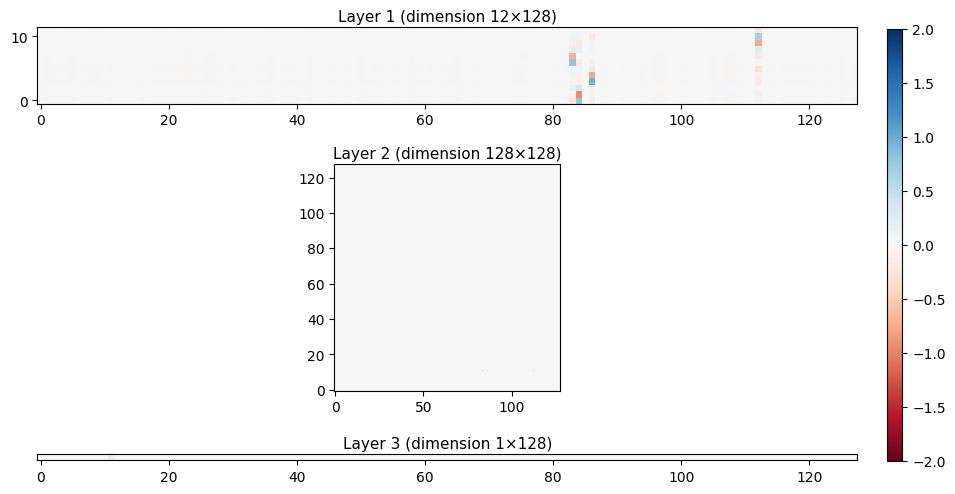

Sparsity of layers.0.weight: 0.00%
Sparsity of layers.1.weight: 23.78%
Sparsity of layers.2.weight: 35.94%


In [83]:
create_all_heatmaps(path)

## Multiple-Seeds Analysis

In [69]:
# Folder with multiple seed-subfolders to be analyzed
path_multiple = "../experiment_output/Experiment4/exp4_l1_init0.2"

### Analyze Average Sparsity

In [76]:
import torch
import os


def load_model_weights(model_path):
    """Load model weights from a .pth file."""
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model_state = checkpoint["student_model_state_dict"]
    return {k: v.cpu().numpy() for k, v in model_state.items() if "weight" in k}

# compute level of sparsity of model
def compute_sparsity(weights_dict):
    """Compute the sparsity of model weights."""
    sparsity = {}
    for layer_name, weights in weights_dict.items():
        num_elements = weights.size
        num_zeros = (abs(weights) < 1e-4).sum()
        sparsity[layer_name] = num_zeros / num_elements    
    return sparsity

def compute_avg_sparsity(directory):
    model_sparsities = {}  # model filename → average sparsity
    best_sparsity = float("-inf")

    for root, _, files in os.walk(directory):
        for file in files:
            if not file.endswith(".pth"):
                continue

            model_path = os.path.join(root, file)
            weights_dict = load_model_weights(model_path)
            sparsity = compute_sparsity(weights_dict)
            avg_sparsity = sum(sparsity.values()) / len(sparsity)

            # append avg sparsity to model_sparsities
            if file in model_sparsities:
                model_sparsities[file].append(avg_sparsity)
            else:
                # Initialize with the first value
                model_sparsities[file] = [avg_sparsity]

    print("\n========== Summary ==========")
    # print avg sparsity and std
    for model_file, avg in model_sparsities.items():
        avg_sparsity = sum(avg) / len(avg) * 100
        std_sparsity = (sum((x*100 - avg_sparsity) ** 2 for x in avg) / len(avg)) ** 0.5
        print(f"{model_file}: {avg_sparsity:.2f}% avg sparsity, {std_sparsity:.2f}% std deviation")



In [77]:
compute_avg_sparsity(path_multiple)


========== Summary ==========
nonoverlappingCNN_sigmoid__fcnn_sigmoid.pth: 66.67% avg sparsity, 0.00% std deviation
nonoverlappingCNN_sigmoid__fcnn_relu.pth: 78.28% avg sparsity, 0.20% std deviation
nonoverlappingCNN_relu__fcnn_tanh.pth: 87.45% avg sparsity, 0.43% std deviation
nonoverlappingCNN_tanh__fcnn_sigmoid.pth: 66.67% avg sparsity, 0.00% std deviation
nonoverlappingCNN_tanh__fcnn_relu.pth: 79.58% avg sparsity, 2.40% std deviation
nonoverlappingCNN_tanh__fcnn_tanh.pth: 98.56% avg sparsity, 0.03% std deviation
nonoverlappingCNN_relu__fcnn_relu.pth: 98.99% avg sparsity, 0.32% std deviation
nonoverlappingCNN_relu__fcnn_sigmoid.pth: 86.21% avg sparsity, 13.68% std deviation
nonoverlappingCNN_sigmoid__fcnn_tanh.pth: 99.02% avg sparsity, 0.11% std deviation


### Get loss average

In [65]:
import os
import re
from collections import defaultdict

def get_loss_dict(root_dir):
    # Dictionary to store all losses grouped by model name
    loss_dict = defaultdict(list)

    # Regex patterns
    transition_pattern = re.compile(r"(nonoverlappingCNN_\w+ -> fcnn_\w+)")
    loss_pattern = re.compile(r"Final Loss:\s*([\d\.eE+-]+)")

    # Walk through all subdirectories and files
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(subdir, file)
                current_key = None

                with open(file_path, "r") as f:
                    for line in f:
                        # Match model transition
                        transition_match = transition_pattern.search(line)
                        if transition_match:
                            current_key = transition_match.group(1)
                            continue

                        # Match final loss if inside a model block
                        if current_key:
                            loss_match = loss_pattern.search(line)
                            if loss_match:
                                final_loss = float(loss_match.group(1))
                                loss_dict[current_key].append(final_loss)
                                current_key = None  # reset for next block

    # Print average losses
    print("\n========== Final Loss Summary ==========")
    for key, losses in loss_dict.items():
        #also compute std per loss
        std_loss = (sum((x - (sum(losses) / len(losses))) ** 2 for x in losses) / len(losses)) ** 0.5
        avg_loss = sum(losses) / len(losses)
        print(f"{key}: Average Final Loss = {avg_loss:.4f} | Standard Deviation = {std_loss:.4f}")


In [66]:
get_loss_dict(path_multiple)


========== Final Loss Summary ==========
nonoverlappingCNN_sigmoid -> fcnn_sigmoid: Average Final Loss = 0.0026 | Standard Deviation = 0.0000
nonoverlappingCNN_sigmoid -> fcnn_relu: Average Final Loss = 0.0109 | Standard Deviation = 0.0001
nonoverlappingCNN_sigmoid -> fcnn_tanh: Average Final Loss = 0.2527 | Standard Deviation = 0.0001
nonoverlappingCNN_relu -> fcnn_sigmoid: Average Final Loss = 3.3092 | Standard Deviation = 0.0218
nonoverlappingCNN_relu -> fcnn_relu: Average Final Loss = 0.0002 | Standard Deviation = 0.0000
nonoverlappingCNN_relu -> fcnn_tanh: Average Final Loss = 3.5502 | Standard Deviation = 0.0215
nonoverlappingCNN_tanh -> fcnn_sigmoid: Average Final Loss = 0.3673 | Standard Deviation = 0.0010
nonoverlappingCNN_tanh -> fcnn_relu: Average Final Loss = 0.1934 | Standard Deviation = 0.0007
nonoverlappingCNN_tanh -> fcnn_tanh: Average Final Loss = 0.0003 | Standard Deviation = 0.0000
